In [1]:
import astropy
import numpy as np
import pandas as pd
import matplotlib
import scipy

from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 
from scipy import stats

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
GASKAP = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits')
GASKAP[0].header

SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    3  /                                               
NAXIS1  =                 3901  /                                               
NAXIS2  =                 3471  /                                               
NAXIS3  =                   84  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BLANK   =                   -1  /                                               
BUNIT   = 'K       '  /                                                         
DATE-OBS= '2019-12-22T06:12:09.7'  /                                            
TELESCOP= 'ASKAP   '  /     

In [4]:
HI4PI = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_HI4PI/mosaic_cube.fits')
HI4PI[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 3901                                                  
NAXIS2  =                 3471                                                  
NAXIS3  =                   71                                                  
CRPIX1  =               2102.0                                                  
CRPIX2  =               1772.0                                                  
CRPIX3  =      39.921630003202                                                  
CRVAL1  =        14.6791666667                                                  
CRVAL2  =   -72.53027777779999                                                  
CRVAL3  =                  0.0                                                  
CDELT1  =    -0.001944444444

In [5]:
# H2 adsorbers w/h central velocities
FUSE = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_H2_components.csv')
FUSE = FUSE[(FUSE["DEC"] < -69) & (FUSE["RA"] < 28)] # relevant stars in SMC

In [6]:
# H2 adsorbers w/o central velocities
FUSE_no_v = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/FUSE_info (SMC + LMC).csv')
FUSE_no_v = FUSE_no_v[(FUSE_no_v["DEC_FK5"] < -69) & (FUSE_no_v["RA_FK5"] < 28)]

In [7]:
# using velocities of C/Cl to substitute in for H2
other_elem = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_H2_other_elem.csv')
other_elem = other_elem[(other_elem["DEC"] < -69) & (other_elem["galaxy_field"] == 'SMC') & (other_elem["RA"] < 28)]

# RELEVANT FUNCTIONS

In [8]:
# FOR HI4PI

def v_indx(v_val): # v_val must be in m/s
    return int((v_val - -51220.42315311206) / (1288.21496912415))

In [10]:
# FOR GASKAP

def v_indx_GASKAP(v_val): # v_val must be in m/s
    return int((v_val - 3.99321598442 * 10 ** 4) / (-9.77198303456 * 10 ** 2))

In [11]:
# make 2D header 

def make_flat_hdr(file):
    hdr = file[0].header
    
    # Make a 2D header 
    flathdr = fits.Header()
    flathdr["NAXIS   "] = 2
    flathdr["NAXIS1  "] = hdr["NAXIS1  "]
    flathdr["NAXIS2  "] = hdr["NAXIS2  "]
    flathdr["CRPIX1  "] = hdr["CRPIX1  "]
    flathdr["CRPIX2  "] = hdr["CRPIX2  "]
    flathdr["CRVAL1  "] = hdr["CRVAL1  "]
    flathdr["CRVAL2  "] = hdr["CRVAL2  "]
    flathdr["CDELT1  "] = hdr["CDELT1  "]
    flathdr["CDELT2  "] = hdr["CDELT2  "]
    flathdr["CTYPE1  "] = hdr["CTYPE1  "]
    flathdr["CTYPE2  "] = hdr["CTYPE2  "]
    flathdr["LONPOLE "] = hdr["LONPOLE "]
    flathdr["LATPOLE "] = hdr["LATPOLE "]
    
    return flathdr

In [12]:
# gives pix vals associated w RA/DEC vals

def pix_vals(flat_FITS_hdr, ra_values, dec_values):
    wcs = WCS(flat_FITS_hdr)
    pix_arr = []
    x_pix = []
    y_pix = []
    for i in range(0, len(ra_values)):
        arr = []
        x_pix, y_pix = wcs.all_world2pix(ra_values[i], dec_values[i], 0)
        arr.append(x_pix)
        arr.append(y_pix)
        pix_arr.append(arr)
    
    return pix_arr

In [13]:
# HI column density values aligning with H2 background stars

def col_dens_arr(pix_arr, col_dens_vals, log = True):
    HI_col_dens = np.zeros(len(pix_arr))
    HI_col_dens_nolog = np.zeros(len(pix_arr))
    for i in range(len(pix_arr)):
        # RA values = 0, Dec = 1 BUT the rows in col_dens_vals = y-values, cols = x-values
        col_dens = col_dens_vals[int(pix_arr[i][1])][int(pix_arr[i][0])] 
        # so the values are logarithmic (to match H2 col dens) and in cm^-2
        HI_col_dens_nolog[i] = col_dens
        HI_col_dens[i] = np.log10(col_dens)
    
    if log:
        return HI_col_dens
    else:
        return HI_col_dens_nolog

In [183]:
# does the actual work of the USM

def process_usm(cc_sum, FWHM = 30., file = HI4PI, low = False):
    
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma) # does smoothing using Gaussian filter
    
    if low:
        sum_USM = sum_smooth
    else:
        sum_USM = cc_sum - sum_smooth
    
    return sum_USM


In [182]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 3 maps at a time    
    tot_cd = np.zeros((3471, 3901))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                tot_cd[np.where(tot_cd < 0.)] = 0.
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[cur:v_indx_max], axis = 0) * (1288.2149691242 * 10 ** -3)
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[cur:cur + 3], axis = 0) * (1288.2149691242 * 10 ** -3)
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        tot_cd += process_usm(cd_arr, FWHM = FWHM)
        cur += 3

    tot_cd[np.where(tot_cd < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_cd

In [184]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd_GASKAP(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 12 maps at a time
    tot_cd = np.zeros((3471, 3901))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 3 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                tot_cd[np.where(tot_cd < 0.)] = 0. 
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[cur:v_indx_max], axis = 0) * 0.977198303456
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[cur:cur + 3], axis = 0) * 0.977198303456
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        cd_arr = process_usm(cd_arr, FWHM = FWHM, file = GASKAP) # high-pass filtering large-scale structure
        cd_arr = process_usm(cd_arr, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering so resolution matches HI4PI
        tot_cd += cd_arr
        cur += 3

    tot_cd[np.where(tot_cd < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_cd

In [18]:
def show_usm(cd, vmin = 0, vmax = 0):
    plt.figure(figsize = (15, 9))
    plt.imshow(np.flip(np.abs(cd), axis = 0), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

In [76]:
# uses all H2 measurements from FUSE 
# = more data points, but some small-scale structure lost due to integration over channel maps
# only works when working with multiple HI channel maps

def HI_H2_integrated(HI_cd_all, HI_cd_all_GASKAP, SS = True, LS = True, xlim = 0, log10 = True):
    
    # using larger catalogue w/o velocities
    FUSE = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/FUSE_info (SMC + LMC).csv')
    FUSE = FUSE[(FUSE["DEC_FK5"] < -69) & (FUSE["Galaxy"] == 'SMC') & (FUSE["RA_FK5"] < 28)]
    FUSE = np.array(FUSE['log10_N_MW'])
    
    HI_cd_pix = np.zeros(len(pix_arr))
    HI_cd_pix_GASKAP = np.zeros(len(pix_arr))
    for i in range(len(pix_arr)):
        if log10:
            HI_cd_pix[i] = np.log10(HI_cd_all[int(pix_arr[i][1])][int(pix_arr[i][0])])
            HI_cd_pix_GASKAP[i] = np.log10(HI_cd_all_GASKAP[int(pix_arr[i][1])][int(pix_arr[i][0])])
        else:
            HI_cd_pix[i] = HI_cd_all[int(pix_arr[i][1])][int(pix_arr[i][0])]
            HI_cd_pix_GASKAP[i] = HI_cd_all_GASKAP[int(pix_arr[i][1])][int(pix_arr[i][0])]
        
    if xlim != 0:
        FUSE = np.delete(FUSE, np.where(HI_cd_pix < xlim))
        HI_cd_pix = np.delete(HI_cd_pix, np.where(HI_cd_pix < xlim))
        
    fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout = True, sharey = True)
    ax1.scatter(HI_cd_pix, FUSE)
    ax2.scatter(HI_cd_pix_GASKAP, FUSE)
    ax1.set_title('HI4PI')
    ax2.set_title('GASKAP')
    
    if SS:
        plt.xlabel('HI Small-Scale Column Densities')
    elif LS:
        plt.xlabel('HI Large-Scale Column Densities')
    else:
        plt.xlabel('HI Total Column Densities')
    ax1.set_ylabel('$H_2$ Column Densities')
    
    return HI_cd_pix, HI_cd_pix_GASKAP, stats.spearmanr(HI_cd_pix, FUSE, nan_policy = 'omit'), stats.spearmanr(HI_cd_pix_GASKAP, FUSE, nan_policy = 'omit')


In [185]:
# returns array to plot HI VS H2 when HI is within +/- 3 km/s of the H2 (or C/Cl velocity)

def HI_H2_one(SS = True, LS = True, log10 = True):
    HI_cd_pix = np.zeros(len(pix_arr2))
    HI_cd_pix_GASKAP = np.zeros(len(pix_arr2))
    
    for i in range(len(FUSE_replaced)):
        v_indx1G = v_indx_GASKAP((FUSE_replaced['vcen'].iloc[i] + 3) * 10 ** 3) 
        v_indx2G = v_indx_GASKAP((FUSE_replaced['vcen'].iloc[i] - 3) * 10 ** 3) 
        v_indx1 = v_indx((FUSE_replaced['vcen'].iloc[i] - 3) * 10 ** 3) # HI4PI
        v_indx2 = v_indx((FUSE_replaced['vcen'].iloc[i] + 3) * 10 ** 3) # HI4PI
        
        if (SS == False) and (LS == False): # using total HI CD instead
            HI_cd_all = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx1:v_indx2,:,:], axis = 0) * (1288.2149691242 * 10 ** -3)
            HI_cd_all_GASKAP = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx1G:v_indx2G,:,:], axis = 0) * 0.244297870185
            HI_cd_all_GASKAP = process_usm(HI_cd_all_GASKAP, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering so resolution matches HI4PI
        else:
            HI_cd_all = usm_cd(v_indx1, v_indx2) # small-scale structure
            HI_cd_all_GASKAP = usm_cd_GASKAP(v_indx1G, v_indx2G)

        if (SS == False) and (LS == True): 
            HI_cd_tot = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx1:v_indx2,:,:], axis = 0) * (1288.2149691242 * 10 ** -3) # total column density
            HI_cd_all = HI_cd_tot - HI_cd_all
                
            HI_cd_tot_GASKAP = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx1G:v_indx2G,:,:], axis = 0) * 0.977198303456
            HI_cd_tot_GASKAP = process_usm(HI_cd_tot_GASKAP, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering so resolution matches HI4PI
            HI_cd_all_GASKAP = HI_cd_tot_GASKAP - HI_cd_all_GASKAP
                
        if log10:
            HI_cd_pix[i] = np.log10(HI_cd_all[int(pix_arr2[i][1])][int(pix_arr2[i][0])])
            HI_cd_pix_GASKAP[i] = np.log10(HI_cd_all_GASKAP[int(pix_arr2[i][1])][int(pix_arr2[i][0])])
        else:
            HI_cd_pix[i] = HI_cd_all[int(pix_arr2[i][1])][int(pix_arr2[i][0])]
            HI_cd_pix_GASKAP[i] = HI_cd_all_GASKAP[int(pix_arr2[i][1])][int(pix_arr2[i][0])]

    return HI_cd_pix, HI_cd_pix_GASKAP
        

In [21]:
# plots total column density

def col_dens(arr, vmin, vmax, title, subtitle):
    wcs = WCS(HI4PI[0].header)
    ax = plt.subplot(projection = wcs, slices = ['x','y',1], zorder = -1)
    plt.grid(b = True, which = 'major', axis = 'both', linewidth = 1, color = 'white')
    plt.xlabel('Right Ascension', fontsize = 20)
    plt.ylabel('Declination', fontsize = 20)
    plt.title(title, y = 1.06, fontsize = 22)
    plt.suptitle(subtitle, x = 0.45, y = 0.93, fontsize = 12)
    plt.imshow(arr, cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

# BASIC PARAMETERS

In [25]:
HI4PI_flat_hdr = make_flat_hdr(HI4PI)

In [26]:
x_col = FUSE_no_v['RA_FK5']
y_col = FUSE_no_v['DEC_FK5']
brightness = FUSE_no_v['log10_N_MW']

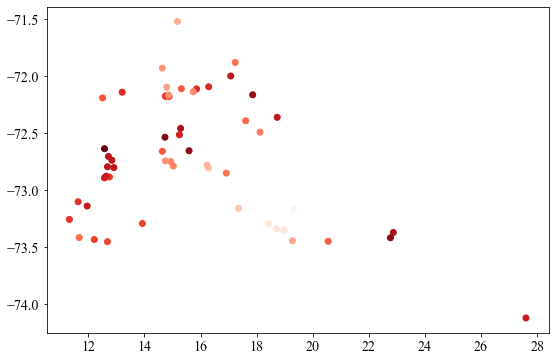

In [27]:
scatter_pts = plt.scatter(x_col, y_col, c = brightness, cmap = 'Reds')
ra_vals = scatter_pts.get_offsets()[:,0]
dec_vals = scatter_pts.get_offsets()[:,1]

In [28]:
pix_arr = pix_vals(HI4PI_flat_hdr, ra_vals, dec_vals)

In [29]:
# rearranging table into arrays for combined C/CI values

other_elem_v = [] # holds (averaged, if necessary) velocities of C/CI
other_elem_stars = [] # holds names of corresponding stars
other_elem_RA = [] # holds corresponding RA values
other_elem_DEC = [] # holds corresponding DEC values

for i in range(len(other_elem)):
    used = True # using current row of elem
    if (np.isnan(other_elem['C_I_vcen'].iloc[i]) == False) & (np.isnan(other_elem['Cl_I_vcen'].iloc[i]) == False):
        other_elem_v.append(np.mean([other_elem['C_I_vcen'].iloc[i], other_elem['Cl_I_vcen'].iloc[i]]))
    elif (np.isnan(other_elem['C_I_vcen'].iloc[i]) == False):
        other_elem_v.append(other_elem['C_I_vcen'].iloc[i])
    elif (np.isnan(other_elem['Cl_I_vcen'].iloc[i]) == False):
        other_elem_v.append(other_elem['Cl_I_vcen'].iloc[i])
    else:
        used = False
        
    if used == True: 
        other_elem_RA.append(other_elem['RA'].iloc[i])
        other_elem_DEC.append(other_elem['DEC'].iloc[i])
        other_elem_stars.append(other_elem['star'].iloc[i])

In [31]:
# replaces central velocities of H2 which have better C/Cl measurements, and deletes those which do not
FUSE_replaced = FUSE 
i = 0
while i < len(FUSE_replaced):
    if FUSE_replaced['star'].iloc[i] in other_elem_stars:
        indx = FUSE_replaced['star'].iloc[i]
        FUSE_replaced['vcen'].iloc[i] = other_elem_v[other_elem_stars.index(indx)]
        other_elem_v.pop(other_elem_stars.index(indx))
        other_elem_stars.pop(other_elem_stars.index(indx))
    else:
        FUSE_replaced = FUSE_replaced.drop(FUSE_replaced.index[i])
        i -= 1
    i += 1

/Users/FRANNYPACK/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
# pix_arr w/h sightlines that have C/Cl velocities

pix_arr2 = pix_vals(HI4PI_flat_hdr, np.array(FUSE_replaced['RA']), np.array(FUSE_replaced['DEC']))

# TOTAL COLUMN DENSITY MAPS

In [186]:
tot_col_dens = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data, axis = 0) * (1288.2149691242 * 10 ** -3) # in cm^-2
GASKAP_tot_cd = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data, axis = 0) * 0.977198303456
GASKAP_tot_cd = process_usm(GASKAP_tot_cd, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 

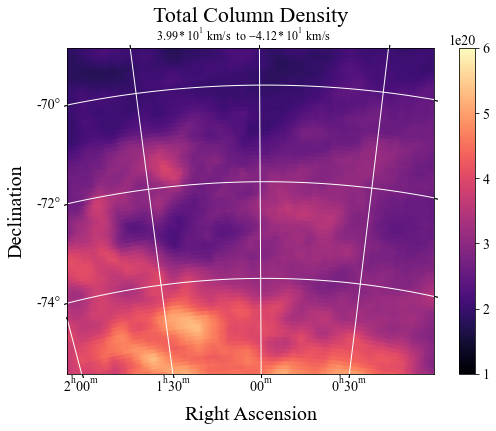

In [38]:
# over entire velocity ranges 

col_dens(tot_col_dens, 1 * 10 ** 20, 0.6 * 10 ** 21, 'Total Column Density', '$\mathregular{3.99 * 10^{1}}$ km/s  to $\mathregular{-4.12 * 10^{1}}$ km/s')


In [187]:
tot_sum = np.sum(tot_col_dens, axis = 1)
tot_sum = tot_sum / np.linalg.norm(tot_sum)
GASKAP_tot_sum = np.sum(GASKAP_tot_cd.astype('float64'), axis = 1)
GASKAP_tot_sum = GASKAP_tot_sum / np.linalg.norm(GASKAP_tot_sum)

In [188]:
np.correlate(tot_sum, GASKAP_tot_sum)

array([0.93786178])

In [189]:
# correlation btwn HI and H2 pixels
HI_tot = col_dens_arr(pix_arr, tot_col_dens)
HI_tot = HI_tot / np.linalg.norm(HI_tot)
HI_tot_GASKAP = col_dens_arr(pix_arr, GASKAP_tot_cd)
HI_tot_GASKAP = HI_tot_GASKAP / np.linalg.norm(HI_tot_GASKAP)
np.correlate(HI_tot, HI_tot_GASKAP)

array([0.99999892])

In [190]:
col_dens2 = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx(-6.95 * 10 ** 3):v_indx(13.5 * 10 ** 3),:,:], axis = 0) * (1288.2149691242 * 10 ** -3)
GASKAP_cd2 = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx_GASKAP(13.5 * 10 ** 3):v_indx_GASKAP(-6.95 * 10 ** 3)], axis = 0) * 0.977198303456
GASKAP_cd2 = process_usm(GASKAP_cd2, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 


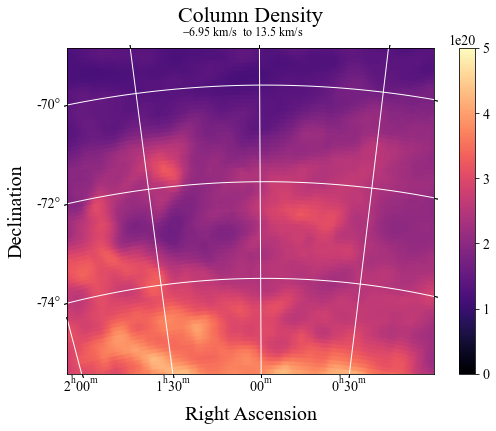

In [46]:

col_dens(col_dens2, 0, 0.5 * 10 ** 21, 'Column Density', '$\mathregular{-6.95}$ km/s  to $\mathregular{13.5}$ km/s')


In [191]:
# correlation btwn total arrays
cd2_sum = np.sum(col_dens2, axis = 1)
cd2_sum = cd2_sum / np.linalg.norm(cd2_sum)
GASKAP_cd2_sum = np.nansum(GASKAP_cd2.astype('float64'), axis = 1)
GASKAP_cd2_sum = GASKAP_cd2_sum / np.linalg.norm(GASKAP_cd2_sum)
np.correlate(cd2_sum, GASKAP_cd2_sum)

array([0.93743789])

In [192]:
# correlation btwn HI and H2 pixels
HI_cd2 = col_dens_arr(pix_arr, col_dens2)
HI_cd2 = HI_cd2 / np.linalg.norm(HI_cd2)
HI_cd2_GASKAP = col_dens_arr(pix_arr, GASKAP_cd2)
HI_cd2_GASKAP = HI_cd2_GASKAP / np.linalg.norm(HI_cd2_GASKAP)
np.correlate(HI_cd2, HI_cd2_GASKAP)

array([0.99999884])

In [193]:
col_dens3 = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx(-20.7 * 10 ** 3):v_indx(-6.95 * 10 ** 3),:,:], axis = 0) * (1288.2149691242 * 10 ** -3)
GASKAP_cd3 = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx_GASKAP(-6.95 * 10 ** 3):v_indx_GASKAP(-20.7 * 10 ** 3),:,:], axis = 0) * 0.977198303456
GASKAP_cd3 = process_usm(GASKAP_cd3, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 



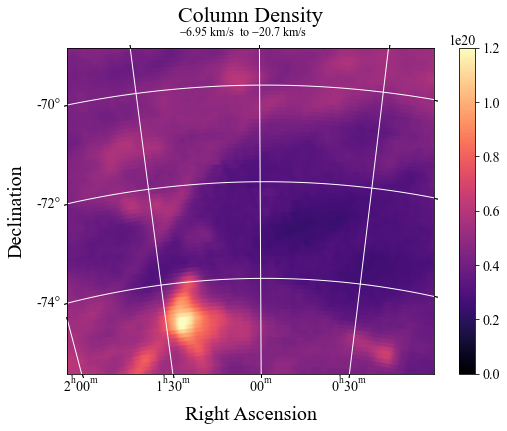

In [54]:

col_dens(col_dens3, 0, 1.2 * 10 ** 20, 'Column Density', '$\mathregular{-6.95}$ km/s  to $\mathregular{-20.7}$ km/s')


In [194]:
cd3_sum = np.sum(col_dens3, axis = 1)
cd3_sum = cd3_sum / np.linalg.norm(cd3_sum)
GASKAP_cd3_sum = np.nansum(GASKAP_cd3.astype('float64'), axis = 1)
GASKAP_cd3_sum = GASKAP_cd3_sum / np.linalg.norm(GASKAP_cd3_sum)
np.correlate(cd3_sum, GASKAP_cd3_sum)

array([0.93468523])

In [195]:
# correlation btwn HI and H2 pixels
HI_cd3 = col_dens_arr(pix_arr, col_dens3)
HI_cd3 = HI_cd3 / np.linalg.norm(HI_cd3)
HI_cd3_GASKAP = col_dens_arr(pix_arr, GASKAP_cd3)
HI_cd3_GASKAP = HI_cd3_GASKAP[np.where(np.isnan(HI_cd3_GASKAP) == False)]
HI_cd3_GASKAP = HI_cd3_GASKAP / np.linalg.norm(HI_cd3_GASKAP)
np.correlate(HI_cd3, HI_cd3_GASKAP)

array([0.99999864])

# (TOTAL) ALL H2 COLUMN DENSITY AGAINST INTEGRATED EMISSION

In [196]:
spearman_rank_integrated_tot = np.zeros((3, 2))
spearman_rank_integrated_tot_GASKAP = np.zeros((3, 2))

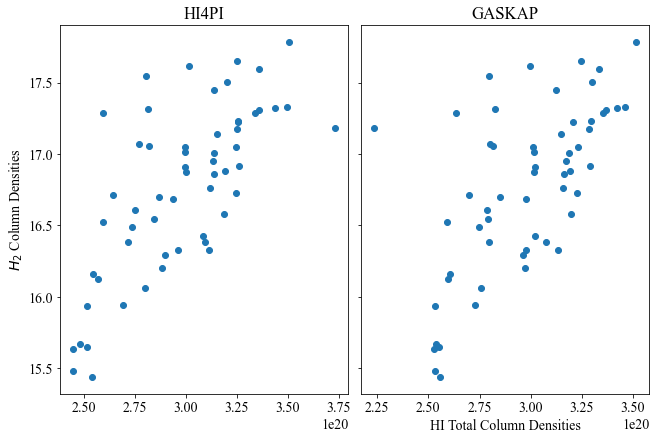

In [197]:
HI_CD_all_pix_tot, HI_CD_all_pix_tot_GASKAP, spearman_rank_integrated_tot[0,:], spearman_rank_integrated_tot_GASKAP[0,:] = HI_H2_integrated(tot_col_dens, GASKAP_tot_cd, SS = False, LS = False, log10 = False)



In [198]:
np.correlate(HI_CD_all_pix_tot / np.linalg.norm(HI_CD_all_pix_tot), HI_CD_all_pix_tot_GASKAP / np.linalg.norm(HI_CD_all_pix_tot_GASKAP))


array([0.99771237])

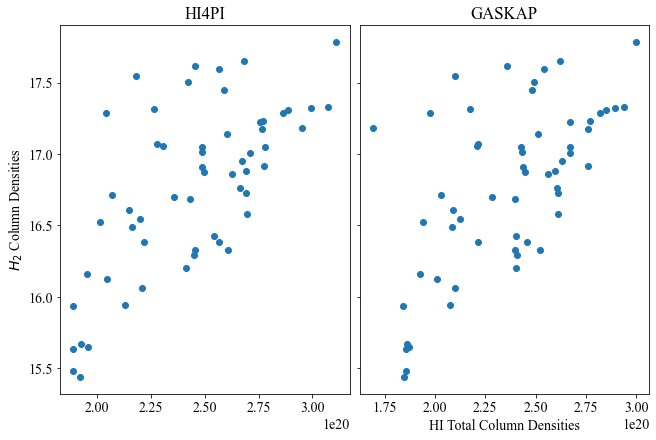

In [199]:
HI_CD_all_pix2, HI_CD_all_pix2_GASKAP, spearman_rank_integrated_tot[1,:], spearman_rank_integrated_tot_GASKAP[1,:] = HI_H2_integrated(col_dens2, GASKAP_cd2, SS = False, LS = False, log10 = False)


In [200]:
np.correlate(HI_CD_all_pix2 / np.linalg.norm(HI_CD_all_pix2), HI_CD_all_pix2_GASKAP / np.linalg.norm(np.linalg.norm(HI_CD_all_pix2_GASKAP)))



array([0.99775092])

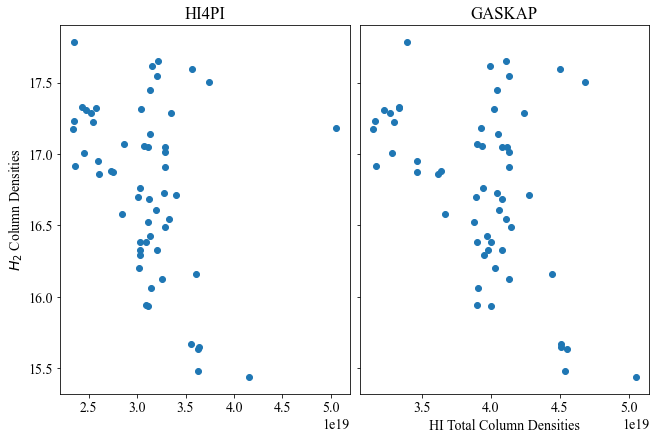

In [201]:
HI_CD_all_pix3, HI_CD_all_pix3_GASKAP, spearman_rank_integrated_tot[2,:], spearman_rank_integrated_tot_GASKAP[2,:] = HI_H2_integrated(col_dens3, GASKAP_cd3, SS = False, LS = False, log10 = False)



In [202]:
np.correlate(HI_CD_all_pix3 / np.linalg.norm(HI_CD_all_pix3), HI_CD_all_pix3_GASKAP / np.linalg.norm(np.linalg.norm(HI_CD_all_pix3_GASKAP)))



array([0.99604613])

In [203]:
spearman_rank_integrated_tot

array([[ 7.05430505e-01,  8.95449571e-10],
       [ 6.23430083e-01,  2.22023338e-07],
       [-3.06577861e-01,  2.03682917e-02]])

In [204]:
spearman_rank_integrated_tot_GASKAP

array([[ 6.56922479e-01,  2.86310050e-08],
       [ 5.94568317e-01,  1.07897759e-06],
       [-3.20910034e-01,  1.49373543e-02]])

# (TOTAL) SELECT H2 COLUMN DENSITY (only where C/Cl measurements = available) AGAINST HI EMISSION @ SPECIFIC VELOCITIES

In [205]:
HI_CD_OE_tot, HI_CD_OE_tot_GASKAP = HI_H2_one(SS = False, LS = False, log10 = False)

In [206]:
np.correlate(HI_CD_OE_tot / np.linalg.norm(HI_CD_OE_tot), HI_CD_OE_tot_GASKAP / np.linalg.norm(HI_CD_OE_tot_GASKAP))

array([0.9875275])

Text(0.5, 1.0, 'GASKAP')

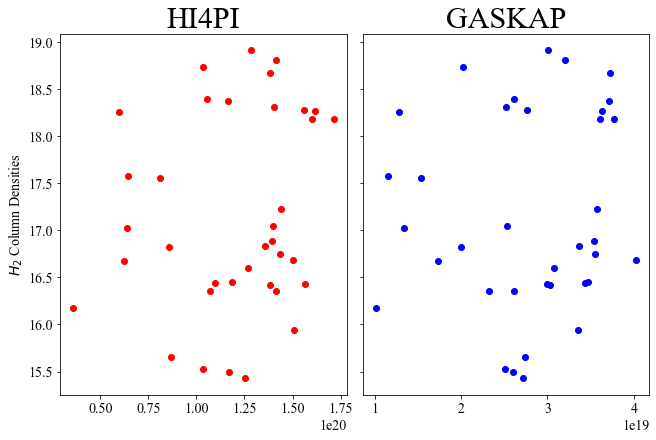

In [207]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, constrained_layout = True)
ax1.scatter(HI_CD_OE_tot, FUSE_replaced['total_log10_N'], c = 'red')
ax2.scatter(HI_CD_OE_tot_GASKAP, FUSE_replaced['total_log10_N'], c = 'blue')
ax1.set_ylabel('$H_2$ Column Densities')
ax1.set_title('HI4PI', fontsize = 30)
ax2.set_title('GASKAP', fontsize = 30)

In [208]:
spearman_rank_one_tot = stats.spearmanr(HI_CD_OE_tot, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
spearman_rank_one_tot_G = stats.spearmanr(HI_CD_OE_tot_GASKAP, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
print(spearman_rank_one_tot)
print(spearman_rank_one_tot_G)

SpearmanrResult(correlation=0.164993564993565, pvalue=0.33623238078890527)
SpearmanrResult(correlation=0.16602316602316602, pvalue=0.3331834074472586)


# (SS) COLUMN DENSITY MAPS

In [97]:
tot_col_dens_SS = usm_cd(0, 70)
tot_col_dens_SSC = np.sum(tot_col_dens_SS, axis = 1)

In [209]:
tot_col_dens_SS_GASKAP = usm_cd_GASKAP(0, 83)
tot_col_dens_SSGC = np.sum(tot_col_dens_SS_GASKAP, axis = 1)

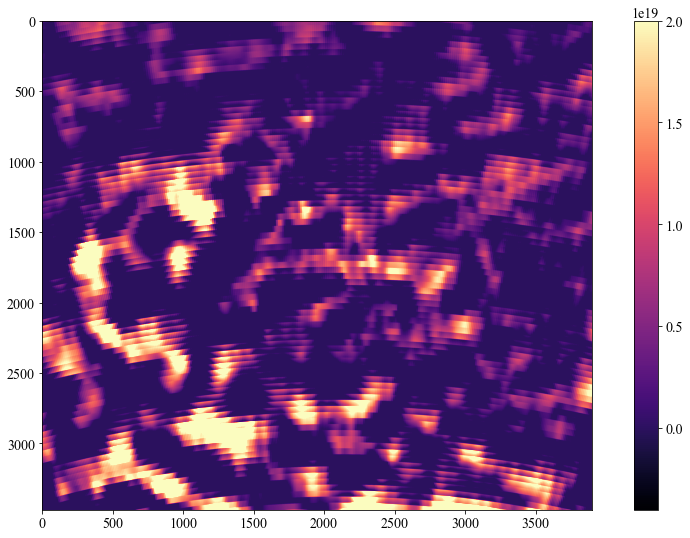

In [102]:
show_usm(tot_col_dens_SS, vmin = -0.4 * 10 ** 19, vmax = 0.2 * 10 ** 20)

Yeah, small-scale correlation ain't looking so nice

In [216]:
# whole small-scale array
np.correlate(tot_col_dens_SSC / np.linalg.norm(tot_col_dens_SSC), tot_col_dens_SSGC / np.linalg.norm(tot_col_dens_SSGC))



array([0.67586431])

In [217]:
# correlation btwn HI and H2 pixels
HI_tot_SS = col_dens_arr(pix_arr, tot_col_dens_SS, log = False)
HI_tot_SS = HI_tot_SS / np.linalg.norm(HI_tot_SS)
HI_tot_SSG = col_dens_arr(pix_arr, tot_col_dens_SS_GASKAP, log = False)
HI_tot_SSG = HI_tot_SSG / np.linalg.norm(HI_tot_SSG)
np.correlate(HI_tot_SS, HI_tot_SSG)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_67767/1897631452.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens[i] = np.log10(col_dens)


array([0.81953764])

In [106]:
col_dens2_SS = usm_cd(v_indx(-6.95 * 10 ** 3), v_indx(13.5 * 10 ** 3))

In [107]:
col_dens2_SSC = np.sum(col_dens2_SS, axis = 1)

In [212]:
col_dens2_SS_GASKAP = usm_cd_GASKAP(25, 44)

In [213]:
col_dens2_SSGC = np.sum(col_dens2_SS_GASKAP, axis = 1)

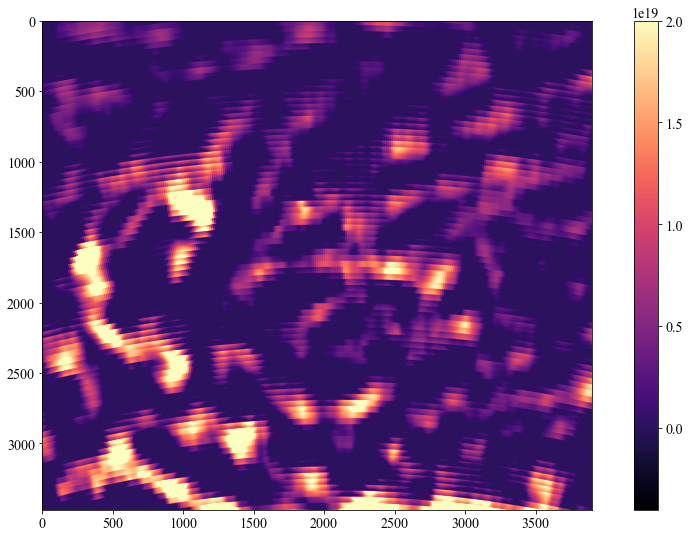

In [110]:
show_usm(col_dens2_SS, vmin = -0.4 * 10 ** 19, vmax = 0.2 * 10 ** 20)

In [215]:
# whole small-scale array
np.correlate(col_dens2_SSC / np.linalg.norm(col_dens2_SSC), col_dens2_SSGC / np.linalg.norm(col_dens2_SSGC))


array([0.63132277])

In [214]:
# correlation btwn HI and H2 pixels
HI_SS2 = col_dens_arr(pix_arr, col_dens2_SS, log = False)
HI_SS2 = HI_SS2 / np.linalg.norm(HI_SS2)
HI_SSG2 = col_dens_arr(pix_arr, col_dens2_SS_GASKAP, log = False)
HI_SSG2 = HI_SSG2 / np.linalg.norm(HI_SSG2)
np.correlate(HI_SS2, HI_SSG2)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_67767/1897631452.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens[i] = np.log10(col_dens)


array([0.87117054])

In [113]:
col_dens3_SS = usm_cd(v_indx(-20.7 * 10 ** 3), v_indx(-6.95 * 10 ** 3))

In [114]:
col_dens3_SSC = np.sum(col_dens3_SS, axis = 1)

In [218]:
col_dens3_SS_GASKAP = usm_cd_GASKAP(44, 59)

In [219]:
col_dens3_SSGC = np.sum(col_dens3_SS_GASKAP, axis = 1)

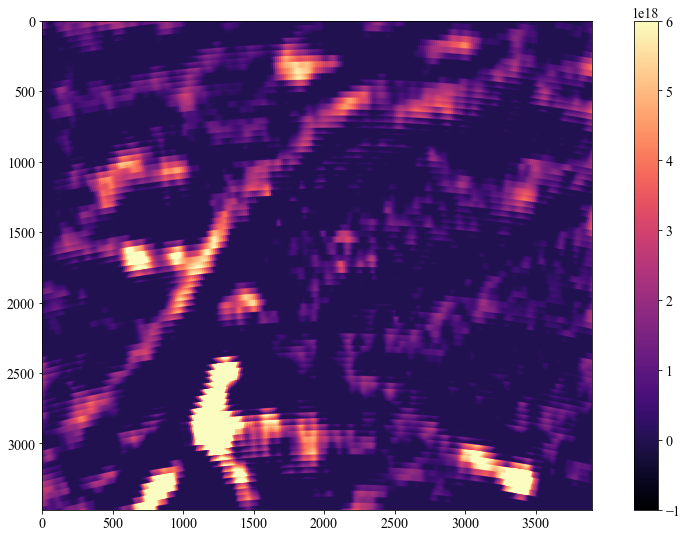

In [121]:
show_usm(col_dens3_SS, vmin = -0.1 * 10 ** 19, vmax = 0.06 * 10 ** 20)

In [220]:
# whole small-scale array
np.correlate(col_dens3_SSC / np.linalg.norm(col_dens3_SSC), col_dens3_SSGC / np.linalg.norm(col_dens3_SSGC))


array([0.79506225])

# (SS) ALL H2 COLUMN DENSITY AGAINST INTEGRATED EMISSION

In [221]:
spearman_rank_integrated_SS = np.zeros((3, 2))
spearman_rank_integrated_SS_GASKAP = np.zeros((3, 2))

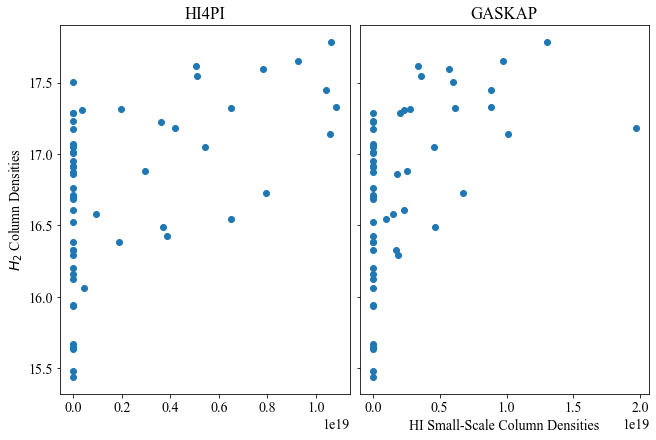

In [222]:
HI_CD_SS_pix_tot, HI_CD_SS_pix_tot_GASKAP, spearman_rank_integrated_SS[0,:], spearman_rank_integrated_SS_GASKAP[0,:] = HI_H2_integrated(tot_col_dens_SS, tot_col_dens_SS_GASKAP, SS = True, LS = False, log10 = False)



In [223]:
np.correlate(HI_CD_SS_pix_tot / np.linalg.norm(HI_CD_SS_pix_tot), HI_CD_SS_pix_tot_GASKAP / np.linalg.norm(HI_CD_SS_pix_tot_GASKAP))


array([0.81953764])

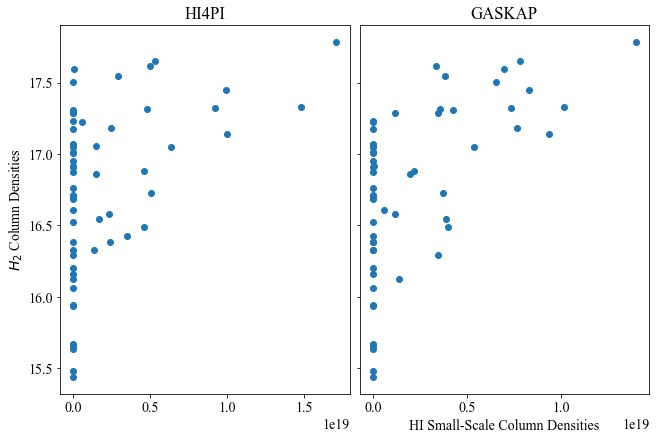

In [224]:
HI_CD_SS_pix2, HI_CD_SS_pix2_GASKAP, spearman_rank_integrated_SS[1,:], spearman_rank_integrated_SS_GASKAP[1,:] = HI_H2_integrated(col_dens2_SS, col_dens2_SS_GASKAP, SS = True, LS = False, log10 = False)


In [225]:
np.correlate(HI_CD_SS_pix2 / np.linalg.norm(HI_CD_SS_pix2), HI_CD_SS_pix2_GASKAP / np.linalg.norm(HI_CD_SS_pix2_GASKAP))


array([0.87117054])

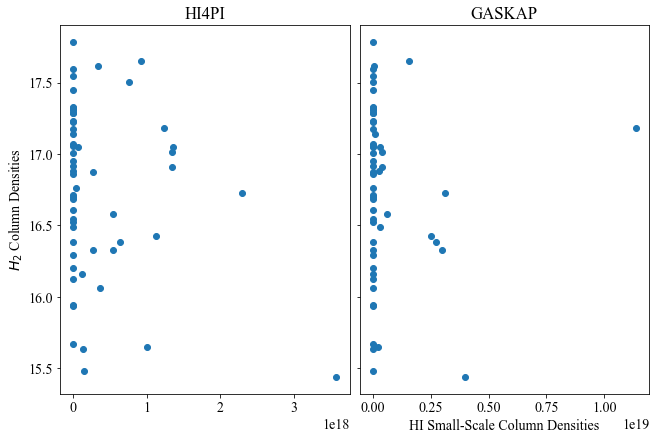

In [226]:
HI_CD_SS_pix3, HI_CD_SS_pix3_GASKAP, spearman_rank_integrated_SS[2,:], spearman_rank_integrated_SS_GASKAP[2,:] = HI_H2_integrated(col_dens3_SS, col_dens3_SS_GASKAP, SS = True, LS = False, log10 = False)


In [227]:
np.correlate(HI_CD_SS_pix3 / np.linalg.norm(HI_CD_SS_pix3), HI_CD_SS_pix3_GASKAP / np.linalg.norm(HI_CD_SS_pix3_GASKAP))


array([0.60113164])

In [228]:
spearman_rank_integrated_SS

array([[ 4.99566584e-01,  7.61606209e-05],
       [ 4.71325977e-01,  2.15066135e-04],
       [-1.90230105e-01,  1.56375651e-01]])

In [229]:
spearman_rank_integrated_SS_GASKAP

array([[ 5.60306344e-01,  5.83343732e-06],
       [ 6.09181900e-01,  4.94180167e-07],
       [-6.74589525e-02,  6.18068898e-01]])

# (SS) SELECT H2 COLUMN DENSITY (only where C/Cl measurements = available) AGAINST HI EMISSION @ SPECIFIC VELOCITIES

In [230]:
HI_CD_OE_SS, HI_CD_OE_SS_GASKAP = HI_H2_one(SS = True, LS = False, log10 = False)

In [231]:
np.correlate(HI_CD_OE_SS / np.linalg.norm(HI_CD_OE_SS), HI_CD_OE_SS_GASKAP / np.linalg.norm(HI_CD_OE_SS_GASKAP))

array([0.90457962])

Text(0.5, 1.0, 'GASKAP')

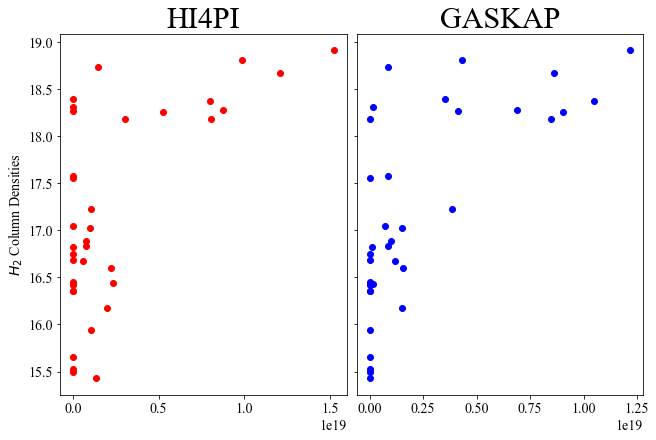

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, constrained_layout = True)
ax1.scatter(HI_CD_OE_SS, FUSE_replaced['total_log10_N'], c = 'red')
ax2.scatter(HI_CD_OE_SS_GASKAP, FUSE_replaced['total_log10_N'], c = 'blue')
ax1.set_ylabel('$H_2$ Column Densities')
ax1.set_title('HI4PI', fontsize = 30)
ax2.set_title('GASKAP', fontsize = 30)

In [233]:
spearman_rank_one_SS = stats.spearmanr(HI_CD_OE_SS, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
spearman_rank_one_SS_G = stats.spearmanr(HI_CD_OE_SS_GASKAP, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
print(spearman_rank_one_SS)
print(spearman_rank_one_SS_G)

SpearmanrResult(correlation=0.4448564584761198, pvalue=0.006557950958031805)
SpearmanrResult(correlation=0.7169320961799548, pvalue=8.703583827424503e-07)


# (LS) COLUMN DENSITY MAPS

In [234]:
tot_col_dens_LS = tot_col_dens - tot_col_dens_SS
tot_col_dens_LS_GASKAP = GASKAP_tot_cd - tot_col_dens_SS_GASKAP

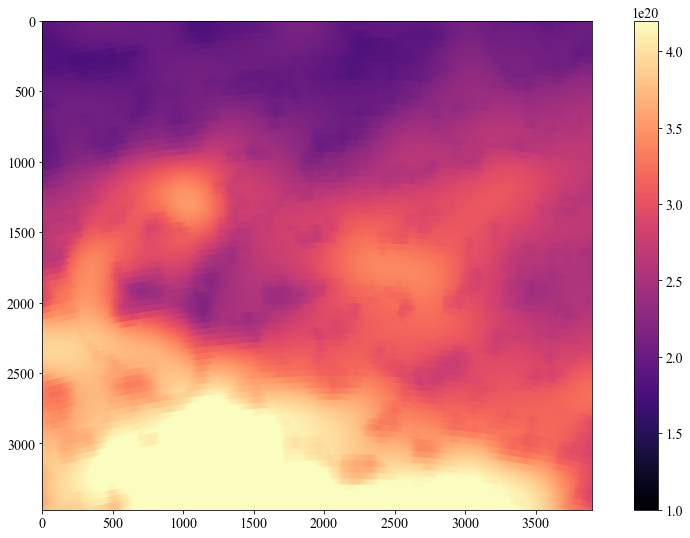

In [155]:
show_usm(tot_col_dens_LS, vmin = 1 * 10 ** 20, vmax = 4.2 * 10 ** 20)

In [235]:
tot_col_dens_LSC = np.sum(tot_col_dens_LS, axis = 1)
tot_col_dens_LSGC = np.sum(tot_col_dens_LS_GASKAP, axis = 1)
np.correlate(tot_col_dens_LSC / np.linalg.norm(tot_col_dens_LSC), tot_col_dens_LSGC / np.linalg.norm(tot_col_dens_LSGC))


array([0.93480117])

In [236]:
# correlation btwn HI and H2 pixels
HI_tot_LS = col_dens_arr(pix_arr, tot_col_dens_LS, log = False)
HI_tot_LS = HI_tot_LS / np.linalg.norm(HI_tot_LS)
HI_tot_LSG = col_dens_arr(pix_arr, tot_col_dens_LS_GASKAP, log = False)
HI_tot_LSG = HI_tot_LSG / np.linalg.norm(HI_tot_LSG)
np.correlate(HI_tot_LS, HI_tot_LSG)

array([0.99721541])

In [237]:
col_dens2_LS = col_dens2 - col_dens2_SS
col_dens2_LS_GASKAP = GASKAP_cd2 - col_dens2_SS_GASKAP

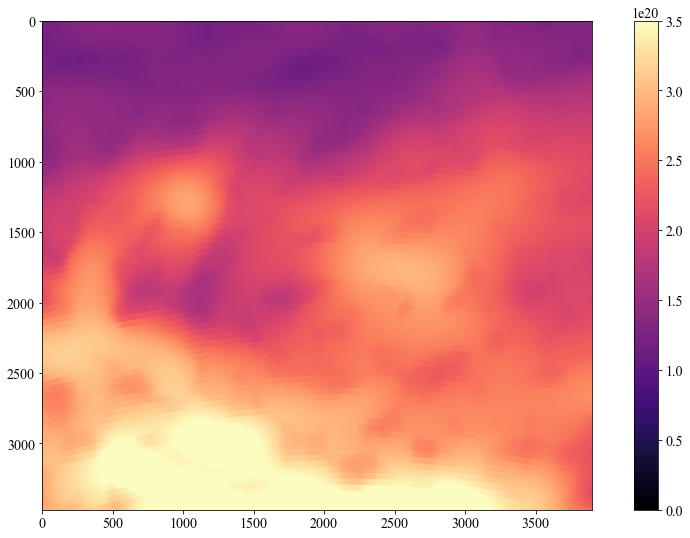

In [159]:
show_usm(col_dens2_LS, vmax = 3.5 * 10 ** 20)

In [238]:
col_dens2_LSC = np.sum(col_dens2_LS, axis = 1)
col_dens2_LSGC = np.sum(col_dens2_LS_GASKAP, axis = 1)
np.correlate(col_dens2_LSC / np.linalg.norm(col_dens2_LSC), col_dens2_LSGC / np.linalg.norm(col_dens2_LSGC))


array([0.93520715])

In [239]:
# correlation btwn HI and H2 pixels
HI_LS2 = col_dens_arr(pix_arr, col_dens2_LS, log = False)
HI_LS2 = HI_LS2 / np.linalg.norm(HI_LS2)
HI_LSG2 = col_dens_arr(pix_arr, col_dens2_LS_GASKAP, log = False)
HI_LSG2 = HI_LSG2 / np.linalg.norm(HI_LSG2)
np.correlate(HI_LS2, HI_LSG2)

array([0.99755735])

In [240]:
col_dens3_LS = col_dens3 - col_dens3_SS
col_dens3_LS_GASKAP = GASKAP_cd3 - col_dens3_SS_GASKAP

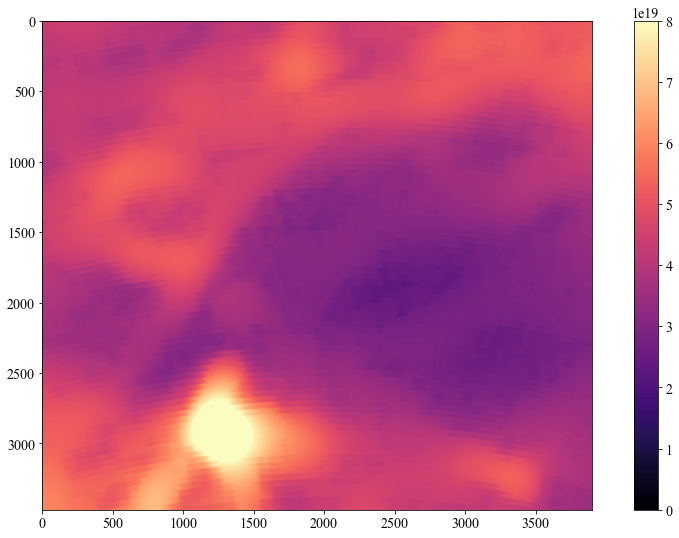

In [162]:
show_usm(col_dens3_LS, vmax = 0.8 * 10 ** 20)

In [241]:
col_dens3_LSC = np.sum(col_dens3_LS, axis = 1)
col_dens3_LSGC = np.sum(col_dens3_LS_GASKAP, axis = 1)
np.correlate(col_dens3_LSC / np.linalg.norm(col_dens3_LSC), col_dens3_LSGC / np.linalg.norm(col_dens3_LSGC))


array([0.9293093])

In [242]:
# correlation btwn HI and H2 pixels
HI_LS3 = col_dens_arr(pix_arr, col_dens3_LS, log = False)
HI_LS3 = HI_LS3 / np.linalg.norm(HI_LS3)
HI_LSG3 = col_dens_arr(pix_arr, col_dens3_LS_GASKAP, log = False)
HI_LSG3 = HI_LSG3 / np.linalg.norm(HI_LSG3)
np.correlate(HI_LS3, HI_LSG3)

array([0.99262273])

# (LS) ALL H2 COLUMN DENSITY AGAINST INTEGRATED HI EMISSION

In [243]:
spearman_rank_integrated_LS = np.zeros((3, 2))
spearman_rank_integrated_LS_GASKAP = np.zeros((3, 2))

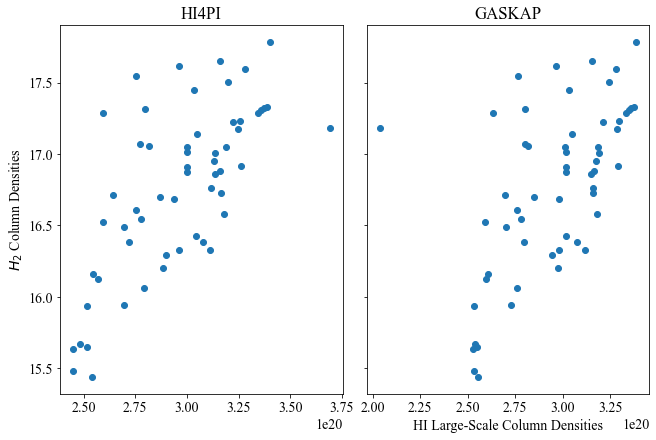

In [244]:
HI_CD_LS_pix_tot, HI_CD_LS_pix_tot_GASKAP, spearman_rank_integrated_LS[0,:], spearman_rank_integrated_LS_GASKAP[0,:] = HI_H2_integrated(tot_col_dens_LS, tot_col_dens_LS_GASKAP, SS = False, LS = True, log10 = False)



In [245]:
np.correlate(HI_CD_LS_pix_tot / np.linalg.norm(HI_CD_LS_pix_tot), HI_CD_LS_pix_tot_GASKAP / np.linalg.norm(HI_CD_LS_pix_tot_GASKAP))



array([0.99721541])

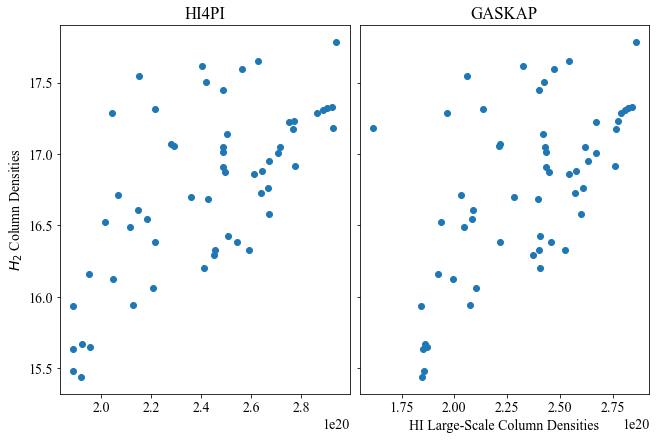

In [246]:
HI_CD_LS_pix2, HI_CD_LS_pix2_GASKAP, spearman_rank_integrated_LS[1,:], spearman_rank_integrated_LS_GASKAP[1,:] = HI_H2_integrated(col_dens2_LS, col_dens2_LS_GASKAP, SS = False, LS = True, log10 = False)



In [247]:
np.correlate(HI_CD_LS_pix2 / np.linalg.norm(HI_CD_LS_pix2), HI_CD_LS_pix2_GASKAP / np.linalg.norm(HI_CD_LS_pix2_GASKAP))



array([0.99755735])

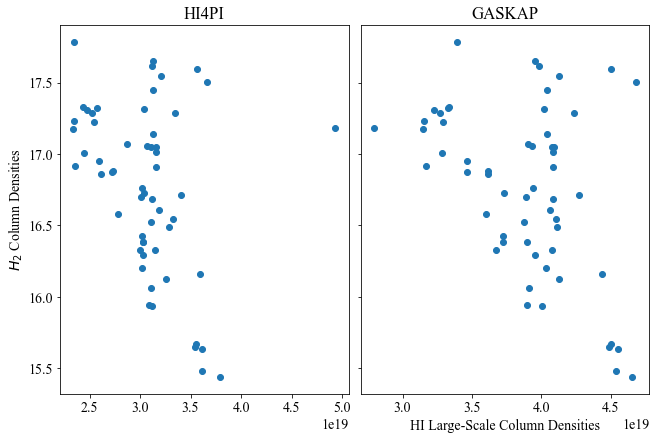

In [248]:
HI_CD_LS_pix3, HI_CD_LS_pix3_GASKAP, spearman_rank_integrated_LS[2,:], spearman_rank_integrated_LS_GASKAP[2,:] = HI_H2_integrated(col_dens3_LS, col_dens3_LS_GASKAP, SS = False, LS = True, log10 = False)



In [249]:
np.correlate(HI_CD_LS_pix3 / np.linalg.norm(HI_CD_LS_pix3), HI_CD_LS_pix3_GASKAP / np.linalg.norm(HI_CD_LS_pix3_GASKAP))



array([0.99262273])

# (LS) SELECT H2 COLUMN DENSITY  (only where C/Cl measurements = available) AGAINST HI EMISSION @ SPECIFIC VELOCITIES

In [250]:
HI_CD_OE_LS, HI_CD_OE_LS_GASKAP = HI_H2_one(SS = False, LS = True, log10 = False)

In [251]:
np.correlate(HI_CD_OE_LS / np.linalg.norm(HI_CD_OE_LS), HI_CD_OE_LS_GASKAP / np.linalg.norm(HI_CD_OE_LS_GASKAP))

array([0.98700716])

Text(0.5, 1.0, 'GASKAP')

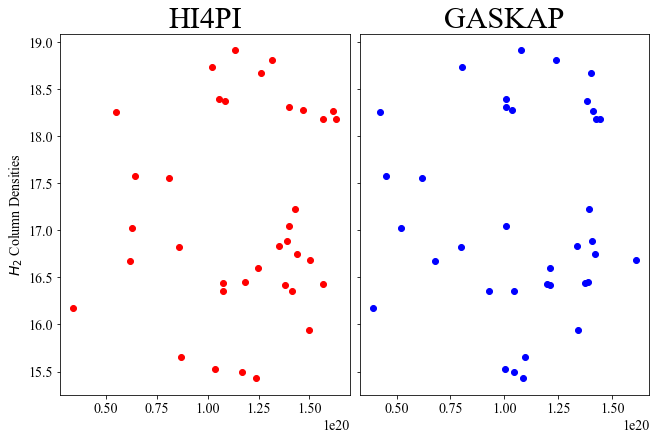

In [252]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, constrained_layout = True)
ax1.scatter(HI_CD_OE_LS, FUSE_replaced['total_log10_N'], c = 'red')
ax2.scatter(HI_CD_OE_LS_GASKAP, FUSE_replaced['total_log10_N'], c = 'blue')
ax1.set_ylabel('$H_2$ Column Densities')
ax1.set_title('HI4PI', fontsize = 30)
ax2.set_title('GASKAP', fontsize = 30)

In [253]:
spearman_rank_one_LS = stats.spearmanr(HI_CD_OE_LS, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
spearman_rank_one_LS_G = stats.spearmanr(HI_CD_OE_LS_GASKAP, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
print(spearman_rank_one_LS)
print(spearman_rank_one_LS_G)

SpearmanrResult(correlation=0.08030888030888031, pvalue=0.6415010301805824)
SpearmanrResult(correlation=0.06975546975546977, pvalue=0.6860251201009837)
